In [1]:
from numba import jit
import numpy as np

@jit(nogil=True, fastmath=True)
def create_polygon_jit(points, n, target_n, gridsize, search_range, curr_area, reached_max_i, val_max_j, reached_min_j, min_area, soln):
    if n >= 3:
        #2 Convex tests
        #convex using cross product(convex check 2)
        x1, y1 = points[n-3][0]-points[n-2][0], points[n-3][1]-points[n-2][1]
        x2, y2 = points[n-1][0]-points[n-2][0], points[n-1][1]-points[n-2][1]
        if x1*y2-x2*y1<=0:
            return False
        #check area > 0 (convex check 3)
        add_area = points[n-1][0]*points[n-2][1]-points[n-1][1]*points[n-2][0]
        if add_area <= 0:
            return False
        #Additionally accute angle not allowed
        if x1*x2+y1*y2>0:
            return True
        #Area
        curr_area += add_area
        if curr_area >= min_area[0]:
            return True
        #Solution found
        if n == target_n:
            min_area[0] = curr_area
            soln[:] = points.copy()
            return True
        #Stage variables
        reached_max_i = reached_max_i or (points[n-1][0] == gridsize - 1)
        if val_max_j < 0:
            if points[n-2][1] > points[n-1][1]:
                val_max_j = points[n-2][1]
        reached_min_j = reached_min_j or (reached_max_i and (points[n-2][1] < points[n-1][1]))

    if not reached_max_i:
        #stage 1,2 i (only move ahead)
        min_i = points[n-1][0]
        max_i = min(gridsize, points[n-1][0] + search_range + 1)
        if val_max_j < 0:
            #stage 1 j (can't do anything)
            min_j = max(1, points[n-1][1] - search_range)
            max_j = min(gridsize, points[n-1][1] + search_range + 1)
        else:
            #stage 2 j (only move down)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = points[n-1][1] + 1
    else:
        #stage 3,4 i (only move back)
        min_i = max(1, points[n-1][0] - search_range)
        max_i = points[n-1][0] + 1
        if not reached_min_j:
            #stage 3 j (can't do anything)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = min(val_max_j, points[n-1][1] + search_range + 1)
        else:
            #stage 4 j (only move up)
            min_j = points[n-1][1]
            max_j = min(0, points[n-1][1] + search_range + 1)

    for i in range(min_i, max_i):
        for j in range(min_j, max_j):
            points[n][0], points[n][1] = i, j
            result = create_polygon_jit(points, n+1, target_n, gridsize, search_range, curr_area, reached_max_i, val_max_j, reached_min_j, min_area, soln)
    points[n][0], points[n][1] = 0,0 #not needed, but nice
    return True

In [2]:
import time
n = 21
gridsize = 16
points = np.array([(0,0)]*n) #List([(0,0)]*n)
results = []
soln = points.copy()
doublearea = np.array([2*gridsize**2])
start = time.perf_counter()
_ = create_polygon_jit(points, 1, n, gridsize, 3, 0, False, -1, False, doublearea, soln)
print(round(time.perf_counter()-start, 2), "seconds,", doublearea[0], "area")
shape = soln.tolist()
print("points:", shape)

343.15 seconds, 289 area
points: [[0, 0], [0, 1], [1, 2], [3, 3], [4, 3], [7, 2], [9, 1], [12, -1], [13, -2], [14, -4], [15, -7], [15, -8], [14, -10], [13, -11], [11, -12], [10, -12], [8, -11], [5, -9], [4, -8], [2, -5], [1, -3]]


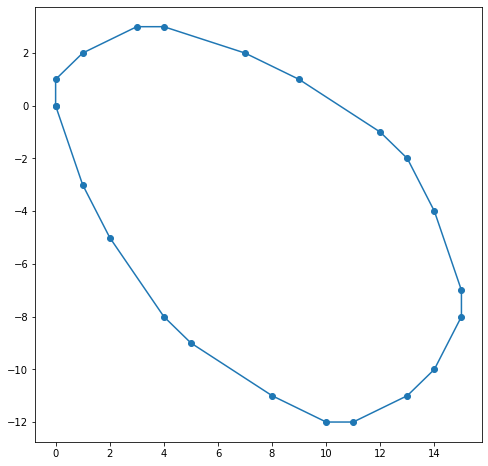

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*shape)
i = list(i) + [i[0]]
j = list(j) + [j[0]]
plt.plot(i,j)
plt.scatter(i,j)
plt.show()